**READ ME:**

    1. PLEASE READ THE COMMENTS ABOVE EVERY CELL BEFORE EXECUTING/COMPILING THE CODE
    
    2. THIS NOTEBOOK DOES THE FOLLOWING -
    
       SECTION 0: SET UP THE NOTEBOOK
       SECTION 1: CLEAN AND PROCESS THE DATA
       
   **SECTION 2: CREATE FEATURES BASED ON USER SESSIONS i.e. A USER'S MULTIPLE INTERACTIONS IN A GIVEN SESSION**
      
      
       SECTION 3: SPLITTING DATA INTO TRAIN AND TEST
       SECTION 4: FEATURE RANKING
       SECTION 5: DATA TRANSFORMATION
       SECTION 6: BASELINING
       SECTION 7: CREATING SAMPLES - NON STRATIFIED
       SECTION 8: CREATING SAMPLES - STRATIFIED
       SECTION 9: T-SNE
       SECTION 10: CLUSTERING

# 0. ***`SETUP`***

## i. SETTING UP NOTEBOOK

In [ ]:
## This Cell is Only for Usage in a Google CoLab Environment
from google.colab import drive

In [ ]:
## This Cell is Only for Usage in a Google CoLab Environment
ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

In [ ]:
## This Cell is Only for Usage in a Google CoLab Environment
%pwd
%cd drive/My Drive/Colab Notebooks/Feature Engineering

## ii. Pre-Processing : Library and Data file import

### Libray Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)
pd.set_option('display.max_columns', 999)

In [3]:
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import gc
import time

In [4]:
plt.rcParams["figure.figsize"] = (8,5)

In [5]:
import imblearn
from imblearn.over_sampling import SMOTE
print(imblearn.__version__)

0.7.0


In [6]:
import collections
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

In [7]:
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

### Data Imports

Original CSV download

TO DOWNLOAD THE **electronics.csv** FILE PLEASE GO TO :

1. https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store
2. Download both the "2019-Nov.csv" and the "2019-Oct.csv" File
3. Combine the csv files. Combined File size should be 13.67 GB
4. For a quick tutorial on how to combine csv files on MAC please refer: https://serp.co/blog/combine-merge-csv-files-mac/

In [8]:
## Run this cell for ELECTRONICS data
electronics = pd.read_csv("electronics.csv")

### Quick File Imports Below 

**Run the cells below if you want to download already processed/compiled data files and skip Sections 1 and 2**

Processed dataframe download

In [10]:
#Run this cell for Electronics Data ONLY
df = pd.read_pickle("dfElectronics.pkl")

Feature Dataset Quick Import

In [ ]:
#Run this cell for ELECTRONICS Data ONLY
FeaturesDF = pd.read_pickle("Electronics_Session_Features.pkl")

## iii. CHECK RAM

In [ ]:
#AVAILABLE SYSTEM RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [10]:
gc.collect()

40

#    
************************************************
************************************************

# 1. ***`PROCESSING DATA`***
Jump to Section 3 if you have imported FeaturesDF files

In [49]:
#Run this cell for ELECTRONICS Data ONLY
df = electronics.copy()

In [53]:
# Run this cell for ELECTRONICS data ONLY

df.drop('category_id',axis=1,inplace=True)

In [54]:
#Dropping rows which have headers in them
headerIndices = df[df['event_time']=='event_time'].index
df.drop(headerIndices,inplace=True)

**IMPORTANT**

**Dropping Categories which are not related to electronics**

**IMPORTANT**

In [55]:
#RUN FOR ELECTRONICS DATA ONLY
df['category_code'] = df['category_code'].astype(str)

In [30]:
#RUN FOR ELECTRONICS DATA ONLY
df['category_code'].unique()

In [56]:
#RUN FOR ELECTRONICS DATA ONLY
nonElectronicCategoriesIndex = df[~(
    df["category_code"].str.contains('appliances') |
    df["category_code"].str.contains('computers') |
    df["category_code"].str.contains('electronics') |
    df["category_code"].str.contains('auto') 
)].index

In [57]:
#RUN FOR ELECTRONICS DATA ONLY
df = df.drop(nonElectronicCategoriesIndex)

**Formatting Date Time Column**

In [60]:
df['event_time'] = pd.to_datetime(df['event_time'],format = '%Y-%m-%d %H:%M:%S %Z')

In [61]:
#Year
df['year'] = (df['event_time']).dt.year

In [62]:
#Month
df['month'] = (df['event_time']).dt.month
MM = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df['month'] = df['month'].map(MM)

In [63]:
# Phase of day
df['hour'] = (df['event_time']).dt.hour
timeOfDay={0:'Dawn',1:'Dawn',2:'Dawn',3:'Dawn',4:'Dawn',5:'EarlyMorning',6:'EarlyMorning',7:'EarlyMorning',8:'EarlyMorning', 9:'Morning',10:'Morning',11:'Morning', 12:'Noon', 13:'Afternoon',14:'Afternoon',15:'Afternoon',16:'Afternoon', 17:'Evening',18:'Evening',19:'Evening',20:'Evening', 21:'Night',22:'Night',23:'Night', 24:'Midnight'}
df['timeOfDay'] = df['hour'].map(timeOfDay)

In [64]:
# Weekday
dayOfWeek={0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fr', 5:'Sat', 6:'Sun'}
df['weekday'] = (df['event_time']).dt.weekday.map(dayOfWeek)

In [65]:
# Is Weekend?
df['Weekend']= df.weekday.apply(lambda x : 1 if x in ['Sunday','Saturday'] else 0)

**Formatting Other Column Types**

In [66]:
df['price']= pd.to_numeric(df['price'])

In [67]:
#DROPPING ROWS WHICH HAVE NEGATIVE VALUE OF PRICE
negative_price = df[df['price']<0]
negative_price = negative_price.index
df = df.drop(negative_price)

In [68]:
df['year']= pd.to_numeric(df['year'])
df['hour']= pd.to_numeric(df['hour'])
df['Weekend']= pd.to_numeric(df['Weekend'])

In [69]:
df['event_type'] = df['event_type'].astype(str)
df['product_id'] = df['product_id'].astype(str)
df['user_id'] = df['user_id'].astype(str)
df['user_session'] = df['user_session'].astype(str)
df['month'] = df['month'].astype(str)
df['weekday'] = df['weekday'].astype(str)
df['timeOfDay'] = df['timeOfDay'].astype(str)

In [12]:
#Dropping Rows where the user_session is NAN

Null_Sessions = df[df['user_session']=='nan'].index
Null_Sessions
df = df.drop(Null_Sessions)

(41521726, 14)

**SAVE TO PICKLE**

In [71]:
## Run this cell only for ELECTRONICS Data ONLY to Save and Load Pickle Files

#df.to_pickle("dfElectronics.pkl")
#df = pd.read_pickle("dfElectronics.pkl")

#    
************************************************
************************************************

# 2. **`CREATING SESSION BASED FEATURES`**

## Features to build:

    Weekday(Sun/Mon/...) [One hot encoded]
    Month [One hot encoded]
    TimeOfDay(Morning/Evening/....) [One hot encoded]
    Weekend
    InteractionTime(Duration of Session in seconds)
    
    NumTotalEventsInSession()
    NumViewEventsInSession
    NumCartEventsInSession
    NumRemoveEventsInSession --- Only for Cosmetics Data
    
    NumCategoriesViewedInSession
    NumCategoriesCartedInSession
    NumCategoriesRemovedInSession --- Only for Cosmetics Data
    
    NumBrandsViewedInSession --- Only for Electronics Data
    NumBrandsCartedInSession --- Only for Electronics Data
    
    NumProductsViewedInSession
    NumProductsCartedInSession
    NumProductsRemovedInSession --- Only for Cosmetics Data
    
    AverageAmountViewedInSession
    AverageAmountCartedInSession
    AverageAmountRemovedInSession --- Only for Cosmetics Data
    
    OverallAmtUserCarted  (The max amount removed by user throughout)
    OverallAmtUserViewed  (The max amount removed by user throughout)
    OverallAmtUserRemoved (The max amount removed by user throughout) --- Only for Cosmetics Data

**NOTE : THE ELECTRONICS DATASET HAS NO REMOVE FEATURE, SO USE BELOW SECTIONS ACCORDINGLY**

1. **MODIFY COMMANDS TO NOT INCLUDE THE 'remove_from_cart' FEATURE when dealing with Electronics Data**

## ADDING COLUMNS TO DF -  AMOUNT BY USER FOR DIFFERENT EVENTS

In [13]:
AmountbyUser = pd.pivot_table(df, index='user_id',columns='event_type',values='price',fill_value=0)

In [14]:
#FOR ELECTRONICS DATA ONLY

AmountbyUser = AmountbyUser.rename(columns={'cart':'OverallAmtUserCarted','purchase':'OverallAmtUserPurchased',
                                            'view':'OverallAmtUserViewed'})

In [15]:
df = pd.merge(df,AmountbyUser,on='user_id',how='left')

## GROUPING THE DATA

by: 'user_session'


In [17]:
GroupUS = df.sort_values('event_time').groupby(['user_session'])

## Total Number of Events/Interactions in Session

In [18]:
Features= GroupUS['event_type'].count().reset_index().rename(columns={'event_type':'TotalEventsInSession'})

In [19]:
Features = Features.set_index('user_session')
Features.head(3)

,TotalEventsInSession
user_session,
00000056-a206-40dd-b174-a072550fa38c,2
00000083-8816-4d58-a9b8-f52f54186edc,6
000001fd-1f89-45e8-a3ce-fe3218cabfad,7


## Duration

In [20]:
# Defining function to return range of any given series
def ammd(series):
    return (max(series)-min(series))

In [21]:
interactionTime = GroupUS['event_time'].agg(ammd)

In [22]:
interactionTime = interactionTime.dt.total_seconds()

In [23]:
Features = Features.join(interactionTime, how='left')
Features = Features.rename(columns={'event_time':'interactionTime'})

In [24]:
Features.head(2)

,TotalEventsInSession,interactionTime
user_session,,
00000056-a206-40dd-b174-a072550fa38c,2,138.0
00000083-8816-4d58-a9b8-f52f54186edc,6,480.0


##  Number of Interactions by Event Type in Session

In [ ]:
#RUN THIS CELL FOR COSMETICS DATA ONLY

NumEventTime = GroupUS['event_type'].value_counts().unstack(fill_value = 0).rename(columns={'view':'NumTimesViewedInSession','cart':'NumTimesCartedInSession',
                                                                                        'purchase':'NumTimesPurchasedInSession','remove_from_cart' : 'NumTimesRemovedInSession'})

In [25]:
#RUN THIS CELL FOR ELECTRONICS DATA ONLY
NumEventTime = GroupUS['event_type'].value_counts().unstack(fill_value = 0).rename(columns={'view':'NumTimesViewedInSession','cart':'NumTimesCartedInSession',
                                                                                            'purchase':'NumTimesPurchasedInSession'})

In [26]:
Features = Features.join(NumEventTime, how ='left')

In [27]:
Features.head(2)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesPurchasedInSession,NumTimesViewedInSession
user_session,,,,,
00000056-a206-40dd-b174-a072550fa38c,2,138.0,0,0,2
00000083-8816-4d58-a9b8-f52f54186edc,6,480.0,1,0,5


## Max and Min Price

In [28]:
Features['maxPrice'] = GroupUS['price'].max().values
Features['minPrice'] = GroupUS['price'].min().values

## AVERAGE AMOUNT BY EVENT IN SESSION

In [29]:
#RUN THIS CELL FOR ELECTRONICS DATA ONLY

AmountbyEvent = pd.pivot_table(df, index='user_session',columns='event_type',values='price',fill_value=0)
AmountbyEvent = AmountbyEvent.rename(columns={'cart':'AvgAmtCartedInSession','purchase':'AvgAmtPurchasedInSession',
                                              'view':'AvgAmtViewedInSession'})

In [30]:
Features = Features.join(AmountbyEvent,how='left')

In [31]:
Features.head(2)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesPurchasedInSession,NumTimesViewedInSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmtViewedInSession
user_session,,,,,,,,,,
00000056-a206-40dd-b174-a072550fa38c,2,138.0,0,0,2,1349.46,955.84,0.00,0.0,1152.650
00000083-8816-4d58-a9b8-f52f54186edc,6,480.0,1,0,5,1153.03,152.58,289.52,0.0,554.408


## BRAND COUNT BY EVENT IN SESSION



In [32]:
##--- RUN THIS CELL FOR THE ELECTRONICS DATA ONLY
##--- IN COSMETICS THE BRAND COLUMN HAS BEEN DROPPED DUE TO EXCESSIVE MISSING DATA

BrandsBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='brand',aggfunc='count',fill_value=0)
BrandsBySession = BrandsBySession.rename(columns={'view':'NumBrandsViewedInSession','cart':'NumBrandsCartedInSession','purchase':'NumBrandsPurchasedInSession'})

In [33]:
##--- RUN THIS CELL FOR THE ELECTRONICS DATA ONLY
##--- IN COSMETICS THE BRAND COLUMN HAS BEEN DROPPED DUE TO EXCESSIVE MISSING DATA
Features = Features.join(BrandsBySession,how='left')

## CATEGORY COUNT BY EVENT IN SESSION

In [34]:
## RUN THIS CELL FOR ELECTRONICS DATA ONLY
## -- FOR THE ELECTRONICS DATA USE :values='category_code'
        
CategoriesBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='category_code',aggfunc='count',fill_value=0)
CategoriesBySession = CategoriesBySession.rename(columns={'view':'NumCategoriesViewedInSession','cart':'NumCategoriesCartedInSession',
                                                          'purchase':'NumCategoriesPurchasedInSession','remove_from_cart' : 'NumCategoriesRemovedInSession'})

In [35]:
Features = Features.join(CategoriesBySession,how='left')

In [36]:
Features.head(2)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesPurchasedInSession,NumTimesViewedInSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmtViewedInSession,NumBrandsCartedInSession,NumBrandsPurchasedInSession,NumBrandsViewedInSession,NumCategoriesCartedInSession,NumCategoriesPurchasedInSession,NumCategoriesViewedInSession
user_session,,,,,,,,,,,,,,,,
00000056-a206-40dd-b174-a072550fa38c,2,138.0,0,0,2,1349.46,955.84,0.00,0.0,1152.650,0,0,2,0,0,2
00000083-8816-4d58-a9b8-f52f54186edc,6,480.0,1,0,5,1153.03,152.58,289.52,0.0,554.408,1,0,5,1,0,5


## ADDING FEATURES FOR AVERAGE OVERALL AMOUNT BY USER FOR DIFFERENT EVENTS

NOTE THAT WE ARE CALCULATING THE MAX AMOUNT OUT OF ALL THE TRANSACTIONS TO DIFFERENTIATE BETWEEN USERS

In [37]:
OverallAmtUserCarted = GroupUS['OverallAmtUserCarted'].max()

In [38]:
OverallAmtUserViewed = GroupUS['OverallAmtUserViewed'].max()

In [39]:
OverallAmtUserPurchased = GroupUS['OverallAmtUserPurchased'].max()

In [40]:
#Merging these individual dataframes

Features = Features.join(OverallAmtUserCarted, how='left')
Features = Features.join(OverallAmtUserViewed, how='left')
Features = Features.join(OverallAmtUserPurchased, how='left')

In [41]:
Features.head(2)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesPurchasedInSession,NumTimesViewedInSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmtViewedInSession,NumBrandsCartedInSession,NumBrandsPurchasedInSession,NumBrandsViewedInSession,NumCategoriesCartedInSession,NumCategoriesPurchasedInSession,NumCategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased
user_session,,,,,,,,,,,,,,,,,,,
00000056-a206-40dd-b174-a072550fa38c,2,138.0,0,0,2,1349.46,955.84,0.00,0.0,1152.650,0,0,2,0,0,2,130.44500,156.047397,98.97000
00000083-8816-4d58-a9b8-f52f54186edc,6,480.0,1,0,5,1153.03,152.58,289.52,0.0,554.408,1,0,5,1,0,5,541.42625,637.564889,530.49625


## PRODUCT COUNT BY EVENT IN SESSION

In [42]:
#RUN THIS CELL FOR ELECTRONICS DATA ONLY
ProductsBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='product_id',aggfunc='count',fill_value=0)
ProductsBySession = ProductsBySession.rename(columns={'view':'NumProdsViewedInSession','cart':'NumProdsCartedInSession',
                                                      'purchase':'NumProdsPurchasedInSession'})

In [43]:
Features = Features.join(ProductsBySession, how='left')

In [44]:
Features.head(1)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesPurchasedInSession,NumTimesViewedInSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmtViewedInSession,NumBrandsCartedInSession,NumBrandsPurchasedInSession,NumBrandsViewedInSession,NumCategoriesCartedInSession,NumCategoriesPurchasedInSession,NumCategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased,NumProdsCartedInSession,NumProdsPurchasedInSession,NumProdsViewedInSession
user_session,,,,,,,,,,,,,,,,,,,,,,
00000056-a206-40dd-b174-a072550fa38c,2,138.0,0,0,2,1349.46,955.84,0.0,0.0,1152.65,0,0,2,0,0,2,130.445,156.047397,98.97,0,0,2


****************************************

**ONE HOT ENCODED FEATURES START HERE**

## Adding Date and Time Features 

By using get_dummies and not pivot_table we went from ~ 365 seconds to ~25 seconds i.e. 14 times faster

In [45]:
weekday = pd.get_dummies(df['weekday']).set_index(df['user_session'])
weekday = weekday.groupby('user_session').max()

In [46]:
year = pd.get_dummies(df['year']).set_index(df['user_session'])
year = year.groupby('user_session').max()

In [47]:
month = pd.get_dummies(df['month']).set_index(df['user_session'])
month = month.groupby('user_session').max()

In [48]:
timeOfDay = pd.get_dummies(df['timeOfDay']).set_index(df['user_session'])
timeOfDay = timeOfDay.groupby('user_session').max()

In [49]:
Features = Features.join(weekday,how='left')
Features = Features.join(year,how='left')
Features = Features.join(month,how='left')
Features = Features.join(timeOfDay,how='left')

In [50]:
Weekend = GroupUS['Weekend'].sum()
Features = Features.join(Weekend,how='left')

In [51]:
Features.head(1)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesPurchasedInSession,NumTimesViewedInSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmtViewedInSession,NumBrandsCartedInSession,NumBrandsPurchasedInSession,NumBrandsViewedInSession,NumCategoriesCartedInSession,NumCategoriesPurchasedInSession,NumCategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased,NumProdsCartedInSession,NumProdsPurchasedInSession,NumProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,Nov,Oct,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Weekend
user_session,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00000056-a206-40dd-b174-a072550fa38c,2,138.0,0,0,2,1349.46,955.84,0.0,0.0,1152.65,0,0,2,0,0,2,130.445,156.047397,98.97,0,0,2,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0


## Dropping all Purchase related Columns and adding Y label 'Purchase'

In [52]:
Features['Purchase'] = Features.NumTimesPurchasedInSession.apply(lambda x : 1 if x!=0 else 0)
Features = Features.reset_index()

In [53]:
Features.columns

Index([                   'user_session',            'TotalEventsInSession',
                       'interactionTime',         'NumTimesCartedInSession',
            'NumTimesPurchasedInSession',         'NumTimesViewedInSession',
                              'maxPrice',                        'minPrice',
                 'AvgAmtCartedInSession',        'AvgAmtPurchasedInSession',
                 'AvgAmtViewedInSession',        'NumBrandsCartedInSession',
           'NumBrandsPurchasedInSession',        'NumBrandsViewedInSession',
          'NumCategoriesCartedInSession', 'NumCategoriesPurchasedInSession',
          'NumCategoriesViewedInSession',            'OverallAmtUserCarted',
                  'OverallAmtUserViewed',         'OverallAmtUserPurchased',
               'NumProdsCartedInSession',      'NumProdsPurchasedInSession',
               'NumProdsViewedInSession',                              'Fr',
                                   'Mon',                             'Sat',

********
Adding row for total events SANS purchase
Dropping all purchase related columns except for label
****

In [ ]:
Features['TotalNonPurchaseEvents'] = Features['TotalEventsInSession']-Features['NumTimesPurchasedInSession']

********
Adding row for total events SANS purchase
Dropping all purchase related columns except for label
****

In [9]:
Features['TotalNonPurchaseEvents'] = Features['TotalEventsInSession']-Features['NumTimesPurchasedInSession']

In [10]:
#RUN THIS CELL FOR ELECTRONICS DATA ONLY

FeaturesDF = Features.drop(columns=['user_session',
                                    'OverallAmtUserPurchased',
                                    'AvgAmtPurchasedInSession',
                                    'NumTimesPurchasedInSession',
                                    'NumCategoriesPurchasedInSession',
                                   'NumProdsPurchasedInSession',
                                    'NumBrandsPurchasedInSession']) 
                           

In [11]:
FeaturesDF.columns

Index([        'TotalEventsInSession',              'interactionTime',
            'NumTimesCartedInSession',      'NumTimesViewedInSession',
                           'maxPrice',                     'minPrice',
              'AvgAmtCartedInSession',        'AvgAmtViewedInSession',
           'NumBrandsCartedInSession',     'NumBrandsViewedInSession',
       'NumCategoriesCartedInSession', 'NumCategoriesViewedInSession',
               'OverallAmtUserCarted',         'OverallAmtUserViewed',
            'NumProdsCartedInSession',      'NumProdsViewedInSession',
                                 'Fr',                          'Mon',
                                'Sat',                          'Sun',
                                'Thu',                          'Tue',
                                'Wed',                           2019,
                                'Nov',                          'Oct',
                          'Afternoon',                         'Dawn',
      

In [12]:
#RUN THIS CELL FOR ELECTRONICS DATA ONLY
FeaturesDF = FeaturesDF[[
    'TotalEventsInSession',              'interactionTime',
            'NumTimesCartedInSession',      'NumTimesViewedInSession',
                           'maxPrice',                     'minPrice',
              'AvgAmtCartedInSession',        'AvgAmtViewedInSession',
           'NumBrandsCartedInSession',     'NumBrandsViewedInSession',
       'NumCategoriesCartedInSession', 'NumCategoriesViewedInSession',
               'OverallAmtUserCarted',         'OverallAmtUserViewed',
            'NumProdsCartedInSession',      'NumProdsViewedInSession',
                                 'Fr',                          'Mon',
                                'Sat',                          'Sun',
                                'Thu',                          'Tue',
                                'Wed',                           2019,
                                'Nov',                          'Oct',
                          'Afternoon',                         'Dawn',
                       'EarlyMorning',                      'Evening',
                            'Morning',                        'Night',
                               'Noon',                      'Weekend',      'TotalNonPurchaseEvents',
                         'Purchase',]]

In [13]:
FeaturesDF.sort_values(by='Purchase',ascending=False)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesViewedInSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtViewedInSession,NumBrandsCartedInSession,NumBrandsViewedInSession,NumCategoriesCartedInSession,NumCategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,NumProdsCartedInSession,NumProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,Nov,Oct,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Weekend,TotalNonPurchaseEvents,Purchase
3319878,6,362.0,2,2,136.12,120.21,128.165000,128.165,2,2,2,2,140.42500,140.845333,2,2,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,4,1
9763568,4,371.0,1,2,424.70,424.70,424.700000,424.700,1,2,1,2,399.90125,393.693902,1,2,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,3,1
9763571,1,0.0,0,0,493.94,493.94,0.000000,0.000,0,0,0,0,0.00000,155.683750,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
8419916,14,778.0,8,5,208.50,169.35,169.350000,177.180,8,5,8,5,169.35000,359.315714,8,5,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,13,1
9763575,3,170.0,1,1,360.11,360.11,360.110000,360.110,1,1,1,1,582.95000,546.976250,1,1,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4180202,2,12.0,0,2,2051.38,1876.89,0.000000,1964.135,0,2,0,2,0.00000,1964.135000,0,2,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,2,0
4180203,3,228.0,1,2,69.45,33.44,69.450000,51.445,1,2,1,2,69.45000,270.670588,1,2,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,3,0
4180204,5,978.0,0,5,463.05,397.93,0.000000,412.862,0,5,0,5,0.00000,446.374167,0,5,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,5,0
4180206,1,0.0,0,1,68.21,68.21,0.000000,68.210,0,0,0,1,0.00000,122.579167,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0


In [14]:
display("The features we have are as follows:", FeaturesDF.columns.tolist())

print('************')
print("PLEASE NOTE THAT \n One-Hot-Encoded Date and Time features are dynamically added as per data")
print('************')

'The features we have are as follows:'

['TotalEventsInSession',
 'interactionTime',
 'NumTimesCartedInSession',
 'NumTimesViewedInSession',
 'maxPrice',
 'minPrice',
 'AvgAmtCartedInSession',
 'AvgAmtViewedInSession',
 'NumBrandsCartedInSession',
 'NumBrandsViewedInSession',
 'NumCategoriesCartedInSession',
 'NumCategoriesViewedInSession',
 'OverallAmtUserCarted',
 'OverallAmtUserViewed',
 'NumProdsCartedInSession',
 'NumProdsViewedInSession',
 'Fr',
 'Mon',
 'Sat',
 'Sun',
 'Thu',
 'Tue',
 'Wed',
 2019,
 'Nov',
 'Oct',
 'Afternoon',
 'Dawn',
 'EarlyMorning',
 'Evening',
 'Morning',
 'Night',
 'Noon',
 'Weekend',
 'TotalNonPurchaseEvents',
 'Purchase']

************
PLEASE NOTE THAT 
 One-Hot-Encoded Date and Time features are dynamically added as per data
************


**Saving Features To Pickle For Quick Access**

In [8]:
#RUN FOR ELECTRONICS DATA ONLY
FeaturesDF.to_pickle('Electronics_Session_Features.pkl')

#    
************************************************
************************************************

#3. ***`SPLITTING DATA`***

## 3a. Test-Train Split

In [15]:
XData = FeaturesDF.iloc[:,:-1]
YData = FeaturesDF.iloc[:,-1]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(XData,YData,test_size=0.2,random_state=42)

## 3b. Scaling with MinMax

In [17]:
MMscaler = MinMaxScaler()
X_train = MMscaler.fit_transform(X_train)
X_test = MMscaler.transform(X_test)

#    
************************************************
************************************************

# 4. ***`FEATURE RANKING`***

## 4a. Using Random Forest

In [65]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))

In [66]:
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [67]:
sel.get_support()

array([ True,  True,  True,  True, False, False,  True, False,  True,
       False,  True,  True, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True])

In [68]:
selected_feat= XData.columns[(sel.get_support())]

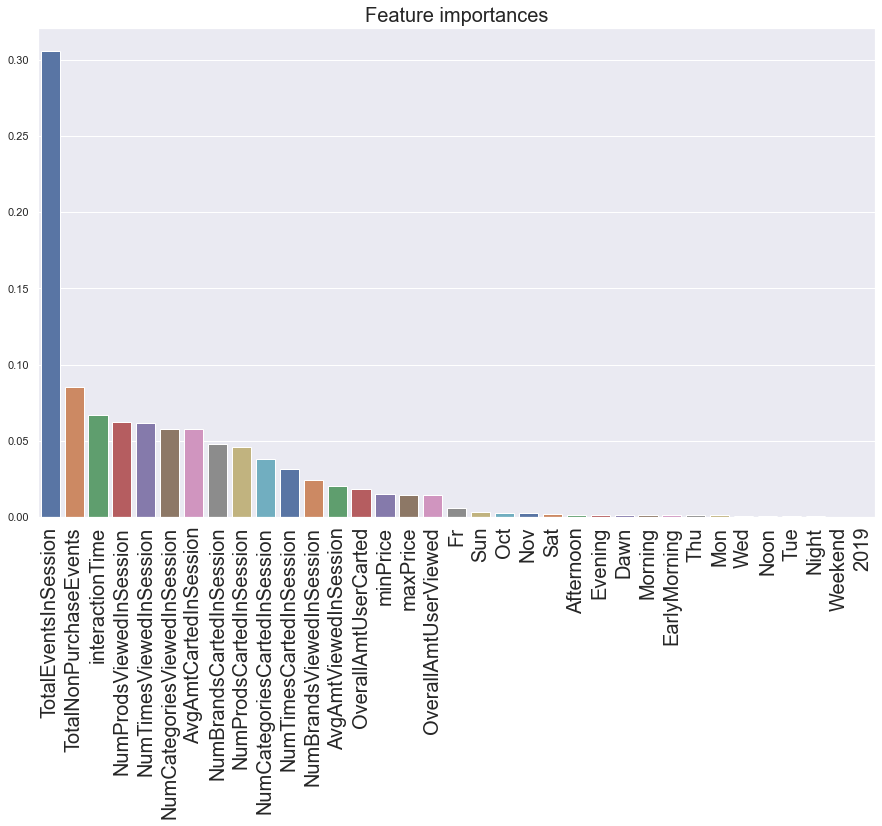

In [69]:
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1] 
colname = XData.columns[indices]
plt.figure(figsize=(15,9))
plt.title("Feature importances",size=20)
sns.barplot(x=colname, y=importances[indices],palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()

## 4b. Using F Scores

In [70]:
import sklearn.feature_selection as fs
kb = fs.SelectKBest(k=X_train.shape[1])
kb.fit(X_train, y_train)
names = XData.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))

In [71]:
fScoreDF = pd.DataFrame(data = names_scores, columns=['Feat_names','F_Scores'])
fScoreDF_sorted = fScoreDF.sort_values(['F_Scores','Feat_names'], ascending =[False, True])

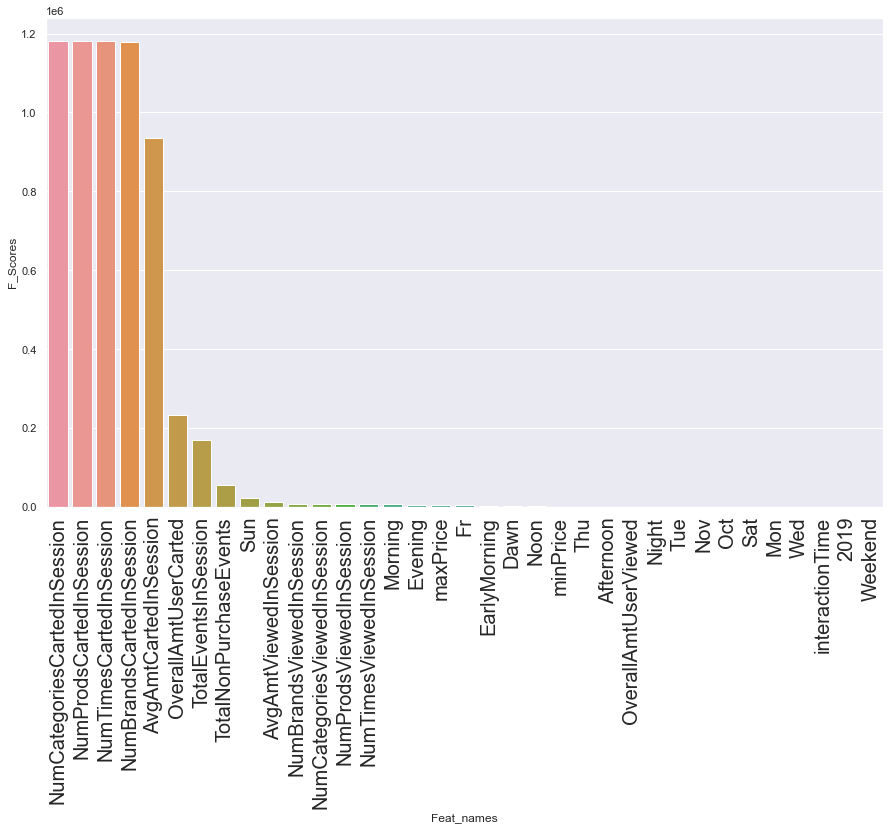

In [72]:
plt.figure(figsize=(15,9))
sns.barplot(x= "Feat_names", y="F_Scores",data=fScoreDF_sorted)
plt.xticks(rotation=90,size=20)
plt.show()

#    
************************************************
************************************************

# 5. ***`DATA TRANSFORMATION`***

## 5.1 SMOTE 

In [18]:
print( "Label Distribution Pre Balancing {}".format(Counter(YData)))

Label Distribution Pre Balancing Counter({0: 11484745, 1: 697559})


In [19]:
oversample = SMOTE()
XSMOTE, YSMOTE = oversample.fit_resample(XData, YData)

In [20]:
print( "Label Distribution Post Balancing {}".format( Counter(YSMOTE) ) )

Label Distribution Post Balancing Counter({0: 11484745, 1: 11484745})


In [21]:
trainX, testX, trainY, testY = train_test_split(XSMOTE,YSMOTE,test_size=0.2,random_state=42)

In [22]:
MMscaler = MinMaxScaler()
trainX = MMscaler.fit_transform(trainX)
testX = MMscaler.transform(testX)

**Save/load pickle files for quick future usage**

In [24]:
#FeaturesDFSMOTE = pd.concat([XSMOTE,YSMOTE],axis=1)
#FeaturesDFSMOTE.to_pickle('Electronics_Session_Features_SMOTE.pkl')
# FeaturesDFSMOTE = pd.read_pickle('Electronics_Session_Features_SMOTE.pkl')

## 5.2 PCA

### 5.2.1 Non Balanced Data

**pca1 : Based on the explained variance percentage**

In [25]:
desiredVariancePercent = 0.8

In [26]:
pca1 = PCA()
pca1.fit(X_train)

PCA()

In [27]:
variance_cumsum = np.cumsum(pca1.explained_variance_ratio_)
variance_cumsum

array([0.20920419, 0.31792289, 0.40521929, 0.47768609, 0.54798284,
       0.6155788 , 0.67780411, 0.7380151 , 0.79716538, 0.85553625,
       0.91159201, 0.94626526, 0.9755026 , 0.98569229, 0.99107779,
       0.99426198, 0.99640327, 0.99802423, 0.99935099, 0.99962372,
       0.9998639 , 0.99995386, 0.99997916, 0.99999485, 0.99999938,
       0.99999985, 0.99999995, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [28]:
numRequiredComponents = next(x[0] for x in enumerate(variance_cumsum.tolist()) if (x[1]> desiredVariancePercent)) + 1
print("Number of components that explain {} percent variance in data are {}".format(desiredVariancePercent*100,numRequiredComponents))

Number of components that explain 80.0 percent variance in data are 10


**pca2 : Number of components defined for variance specified above**

In [29]:
pca2 = PCA(n_components=numRequiredComponents)
pca2.fit(X_train)

PCA(n_components=10)

In [30]:
np.cumsum(pca2.explained_variance_ratio_)

array([0.20920419, 0.31792289, 0.40521929, 0.47768609, 0.54798284,
       0.6155788 , 0.67780411, 0.7380151 , 0.79716538, 0.85553625])

**pcaNC2 : Number of components = 2**

In [ ]:
pcaNC2 = PCA(n_components=2)
pcaNC2.fit(X_train)

**Visualization of Explained Variance Ratio For different components**

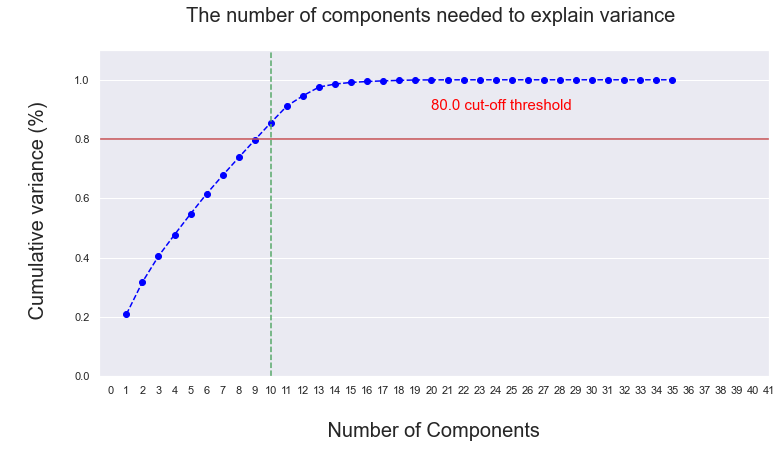

In [32]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, FeaturesDF.shape[1], step=1)
y = np.cumsum(pca1.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='blue')

plt.xlabel('\n Number of Components \n',size = 20)
plt.xticks(np.arange(0, FeaturesDF.shape[1], step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('\n Cumulative variance (%)\n ',size = 20)
plt.title('The number of components needed to explain variance \n',size = 20)

plt.axhline(y= desiredVariancePercent, color='r', linestyle='-')
plt.axvline(x=numRequiredComponents, color='g', linestyle='--')
plt.text(20, 0.9, '{} cut-off threshold'.format(desiredVariancePercent*100), color = 'red', fontsize=15)

ax.grid(axis='x')
plt.show()

### 5.2.2 Balanced Data

**smote_pca : Number of components NOT defined**

In [33]:
smote_pca = PCA()
smote_pca.fit(trainX)

PCA()

In [36]:
variance_cumsumSMOTE = np.cumsum(smote_pca.explained_variance_ratio_)

In [37]:
numRequiredComponentsSMOTE = next(x[0] for x in enumerate(variance_cumsumSMOTE.tolist()) if (x[1]> desiredVariancePercent)) + 1
print("Number of components that explain {} percent variance in data are {}".format(desiredVariancePercent*100,numRequiredComponentsSMOTE))

Number of components that explain 80.0 percent variance in data are 11


**smote_pca2 : Number of components defined for variance specified**

In [38]:
smote_pca2 = PCA(n_components=numRequiredComponentsSMOTE)
smote_pca2.fit(trainX)

PCA(n_components=11)

**smotePcaNC2 : Number of components = 2**

In [ ]:
smote_pcaNC2 = PCA(n_components=2)
smote_pcaNC2.fit(X_train)

**SMOTE PCA Visualization**

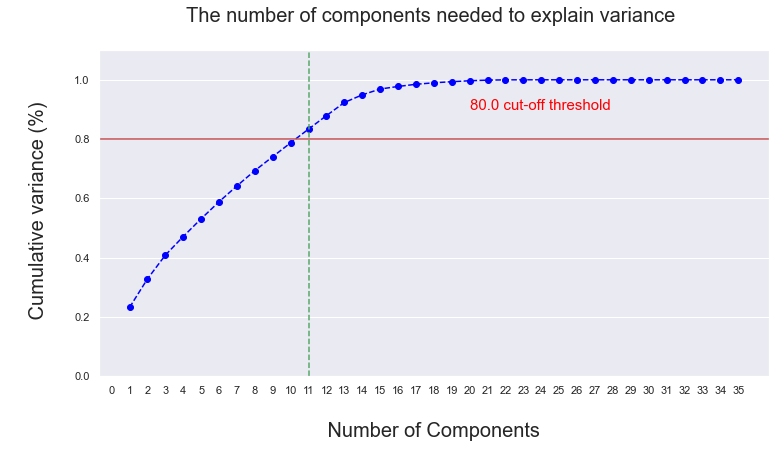

In [40]:
fig, ax = plt.subplots()
xi = np.arange(1, FeaturesDF.shape[1], step=1)
y = np.cumsum(smote_pca.explained_variance_ratio_)
NTH_component = next(x[0] for x in enumerate(y.tolist()) if (x[1]> desiredVariancePercent))

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='blue')

plt.xlabel('\n Number of Components \n',size = 20)
plt.xticks(np.arange(0, FeaturesDF.shape[1], step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('\n Cumulative variance (%)\n ',size = 20)
plt.title('The number of components needed to explain variance \n',size = 20)

plt.axhline(y= desiredVariancePercent, color='r', linestyle='-')
plt.axvline(x=NTH_component+1, color='g', linestyle='--')
plt.text(20, 0.9, '{} cut-off threshold'.format(desiredVariancePercent*100), color = 'red', fontsize=15)

ax.grid(axis='x')
plt.show()

### 5.2.3 PCA Transformations

Non Balanced Data --- 

CHOOSE the function you want to use depending on variance/number of components :

1. pca1
2. pca2
3. pcaNC2

In [41]:
X_train = pca2.transform(X_train)
X_test = pca2.transform(X_test)

In [1]:
X_PCA = np.concatenate([X_train_pca,X_test_pca])

In [ ]:
X_PCA.shape

Balanced Data

In [48]:
trainX = smote_pca2.transform(trainX)
testX = smote_pca2.transform(testX)

In [49]:
trainX.shape

(18375592, 11)

#    
************************************************
************************************************

# 6. ***`BASELINING`***

## 6a. BASELINING --- non Balanced data

In [51]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000,n_jobs=-1)

In [52]:
y_pred = cross_val_predict(logreg, X_train, y_train, cv=5)

In [53]:
print(metrics.accuracy_score(y_train, y_pred))

0.9427396891166828


In [54]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [55]:
y_predFinal = logreg.predict(X_test)

In [56]:
print(metrics.accuracy_score(y_test, y_predFinal))

0.9427411315017971


In [57]:
cnf_matrix = metrics.confusion_matrix(y_test, y_predFinal)
cnf_matrix

array([[2296952,       0],
       [ 139509,       0]])

Text(0.5, 30.5, 'Predicted label')

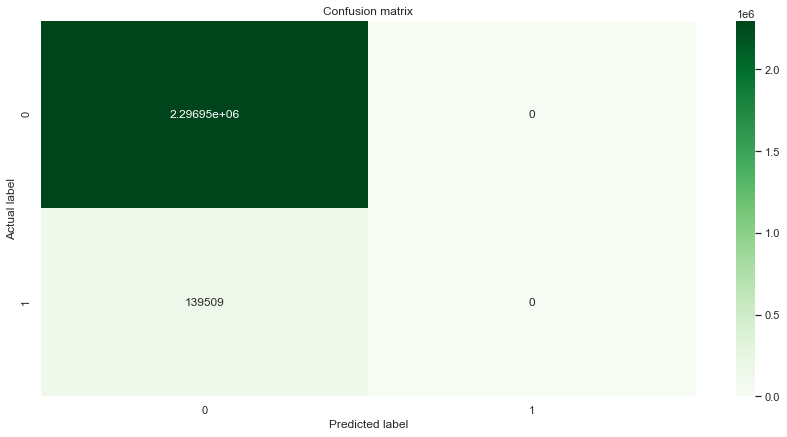

In [58]:
class_names=[1,0] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Greens" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [59]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predFinal))
print("Precision:",metrics.precision_score(y_test, y_predFinal))
print("Recall:",metrics.recall_score(y_test, y_predFinal))

Accuracy: 0.9427411315017971
Precision: 0.0
Recall: 0.0


## 6b. BASELINING - Balanced data

In [60]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000,n_jobs=-1)

In [61]:
predY = cross_val_predict(logreg, trainX, trainY, cv=5)

In [62]:
print(metrics.accuracy_score(trainY, predY))

0.9196609284751207


In [63]:
logreg.fit(trainX, trainY)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [64]:
predFinalY = logreg.predict(testX)

In [65]:
print(metrics.accuracy_score(testY, predFinalY))

0.9197550751017981


In [66]:
cnf_matrix_SMOTE = metrics.confusion_matrix(testY, predFinalY)
cnf_matrix_SMOTE

array([[2130361,  165792],
       [ 202845, 2094900]])

Text(0.5, 21.5, 'Predicted label SMOTE')

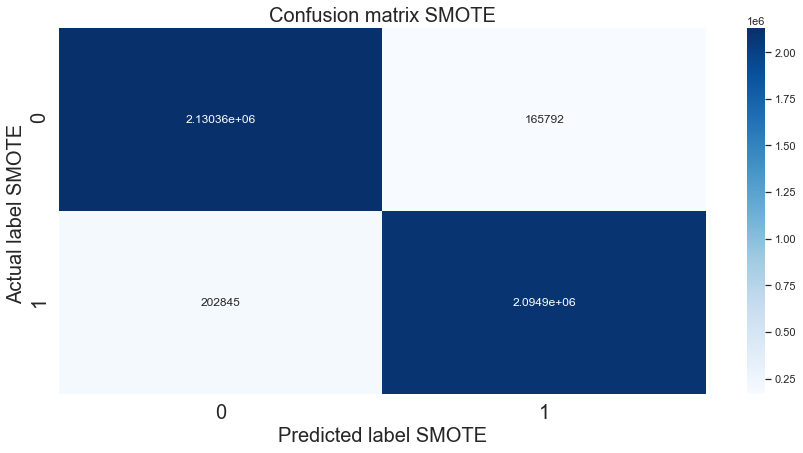

In [67]:
# name  of classes
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names,size=20)
plt.yticks(tick_marks, class_names,size=20)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_SMOTE), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix SMOTE',size = 20)
plt.ylabel('Actual label SMOTE ',size = 20)
plt.xlabel('Predicted label SMOTE',size = 20)

In [68]:
print("Accuracy:",metrics.accuracy_score(testY, predFinalY))
print("Precision:",metrics.precision_score(testY, predFinalY))
print("Recall:",metrics.recall_score(testY, predFinalY))

Accuracy: 0.9197550751017981
Precision: 0.9266631633145958
Recall: 0.9117199689260558


#    
************************************************
************************************************

# 7. ***`SUBSETTING DATA/CREATING SAMPLES`***

**NON STRATIFIED**

    FeaturesDF - All Features
    XData, YData - FeaturesDF split into x and y
    X,Y - SMOTE of XData and YData
    XSelect,YSelect- XData with select features
    XSample,YSample - XSelect Sliced upto 'n' rows non stratified

In [69]:
print(XData.shape)
print(YData.shape)

(12182304, 35)

In [ ]:
# FOR ELECTRONICS DATA

SelectFeatures = ['TotalEventsInSession', 'interactionTime',
                  'NumTimesCartedinSession','NumTimesViewedinSession',             
                         'maxPrice',    'minPrice',         
           'AvgAmtCartedInSession',  'AvgAmtViewedInSession',
        'NumCategoriesCartedinSession', 'NumCategoriesViewedinSession',
                  'OverallAmtUserCarted','OverallAmtUserViewed',
             'NumProdsCartedInSession',   'NumProdsViewedInSession'   ,
                 'NumBrandsCartedInSession',   'NumBrandsViewedInSession'    ]

**Subsets for clustering**

In [ ]:
#Enter the desired subset size

Subset_size = XData.shape[0] # All Rows

# OR

Subset_size = 60000 # Specified number of rows

In [ ]:
#CREATING X SAMPLE

XSelect = XData[SelectFeatures]
XSample = XSelect[:Subset_size].iloc[:,:]

In [ ]:
#Scaling X SAMPLE

MMscaler = MinMaxScaler()
SampleCol = XSample.columns
XSample = MMscaler.fit_transform(XSample)
XSample = pd.DataFrame(XSample,columns=SampleCol)

print(XSample.shape)

In [ ]:
#CREATING Y SAMPLE

YSample = YData[:Subset_size]
print(YSample.value_counts())

#    
************************************************
************************************************

# 8. ***`STRATIFIED SAMPLING`***

XSampleSS - Stratified X Sample

YSampleSS - Stratified Y Sample


## Generating Sample

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size = 0.009, random_state=42)


In [ ]:
for train_index, test_index in sss.split(XData, YData):
    XSSS_Train = XData.loc[train_index]
    XSSS_Test = XData.loc[test_index]
    YSSS_Train = YData.loc[train_index]
    YSSS_Test = YData.loc[test_index]


In [ ]:
XSampleSS = XSSS_Test
print(XSampleSS.shape)
YSampleSS = YSSS_Test
print(YSampleSS.shape)

In [ ]:
# FOR ELECTRONICS DATA

SelectFeatures = ['TotalEventsInSession', 'interactionTime',
                  'NumTimesCartedinSession','NumTimesViewedinSession',             
                         'maxPrice',    'minPrice',         
           'AvgAmtCartedInSession',  'AvgAmtViewedInSession',
        'NumCategoriesCartedinSession', 'NumCategoriesViewedinSession',
                  'OverallAmtUserCarted','OverallAmtUserViewed',
             'NumProdsCartedInSession',   'NumProdsViewedInSession'   ,
                 'NumBrandsCartedInSession',   'NumBrandsViewedInSession'    ]

In [ ]:
#Creating Stratified X Sample

XSampleSS = XSampleSS[SelectFeatures]

XSampleSS = XSampleSS.iloc[:,:]
SampleColSS = XSampleSS.columns

XSampleSS = MMscaler.fit_transform(XSampleSS)
XSampleSS = pd.DataFrame(XSampleSS,columns=SampleColSS)

In [ ]:
#Creating Stratified Y Sample
YSampleSS = YSampleSS.Purchase

#    
************************************************
************************************************

# 9. ***`T-SNE`***

## T-SNE FUNCTIONS SETUP

In [ ]:
def generate_tsne(sample_X, sample_Y, perp):
    
    """
    Parameter : Perplexity (5 to 50, increase with density)
    Returns: tsne modified dataframe
    """
    
    tsne = TSNE(n_components=2, perplexity = perp, n_iter = 300, learning_rate=100)
    tsne_results = tsne.fit_transform(sample_X)
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1','comp2'])
    df_tsne['label'] = sample_Y.values
    return df_tsne

In [ ]:
def viz_TSNE(df_tsne):
    
    """
    Parameter :tsne modified dataframe
    Returns: Visualization of tsne
    """
    
    plt.figure(figsize=(9,6))
    sns.lmplot(x='comp1', y='comp2', data = df_tsne, hue='label', fit_reg=False)
    plt.show()

## **TSNE ITERATIONS**

### Trial 1

Using a Stratified Sample

(n_components=2, perplexity = perp, n_iter = 1000, learning_rate=100)

***1.1
Perplexity = 10***

In [ ]:
dfSS10 = generate_tsne(XSampleSS, YSampleSS, 10)

In [ ]:
viz_TSNE(dfSS10)

***1.2
Perplexity = 20***

In [ ]:
dfSS20= generate_tsne(XSampleSS, YSampleSS, 20)

In [ ]:
viz_TSNE(dfSS20)

***1.3
Perplexity = 30***

In [ ]:
dfSS30= generate_tsne(XSampleSS, YSampleSS, 30)

In [ ]:
viz_TSNE(dfSS30)

***1.4
Perplexity = 50***

In [ ]:
dfSS50= generate_tsne(XSampleSS, YSampleSS, 50)

In [ ]:
viz_TSNE(dfSS50)

#    
************************************************
************************************************

# 10. ***`CLUSTERING`***

## DBSCAN FUNCTION

In [ ]:
def dbscan(X, eps, min_samples):
    """
    Parameters: 
    X: the X dataframe for clustering
    eps : min distance between points in a cluster
    min_samples: min number of data points in a sample
    
    Returns:
        A DBSCAN visualiazation
        Estimated number of clusters
    """   
    
    X = X.iloc[:,:].values
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    print('Estimated number of clusters: %d' % n_clusters_)

####  *Finding Optimal Eps value for DBSCAN*

In [ ]:
NN = NearestNeighbors(n_neighbors=100)
nbrs = NN.fit(XSampleSS)

In [ ]:
distances, indices = nbrs.kneighbors(XSampleSS)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.ylim([0,1])
plt.show()

## CLUSTERING after PCA

In [ ]:
# FITTING the stratified sample through PCA
pcaNC2 = PCA(n_components=2)
pcaNC2.fit(XSampleSS)

In [ ]:
# Transforming the stratified sample through PCA
XSampleSS_pca = pcaNC2.transform(XSampleSS)

In [ ]:
#RUNNING DBSCAN WITH EPS = 0.005 AND MIN_SAMPLE = 1000

dbscan(pd.DataFrame(XSampleSS_pca),0.005,1000)

In [ ]:
#RUNNING DBSCAN WITH EPS = 0.005 AND MIN_SAMPLE = 100

dbscan(pd.DataFrame(XSampleSS_pca),0.005,100)

In [ ]:
#RUNNING DBSCAN WITH EPS = 0.03

dbscan(pd.DataFrame(XSampleSS_pca),0.03,1000)

## CLUSTERING after TSNE

In [ ]:
dfX10 = dfSS10.loc[:,:'comp2']
dbscan(dfX10, 0.005, 1000)

In [ ]:
dfX20 = dfSS20.loc[:,:'comp2']
dbscan(dfX20, 0.007, 1000)

In [ ]:
dfX30 = dfSS30.loc[:,:'comp2']
dbscan(dfX30, 0.007, 1000)

## CLUSTERING after PCA + TSNE

**STEP 1 PCA**

In [ ]:
# FITTING the stratified sample through PCA
pcaNC2 = PCA(n_components=2)
pcaNC2.fit(XSampleSS)

In [ ]:
# Transforming the stratified sample through PCA
XSS_pca = pcaNC2.transform(XSampleSS)

**STEP 2 TSNE**

In [ ]:
# Running TSNE with perplexity = 20
df_tsne_pca = generate_tsne(XSS_pca, YSampleSS, 20)

In [ ]:
viz_TSNE(df_tsne_pca)

**STEP 3 Cluster Visualizations**

In [ ]:
#clustering using DBSCAN with eps = 0.03 and min_sample = 1000
dbscan(pd.DataFrame(df_tsne_pca),0.03,1000)

#    
************************************************
************************************************